In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.mobility_data_manager import DataManager
from utils.common import load_data, Data


SELECTED_DATA= Data.SMALL

In [2]:
df = load_data(SELECTED_DATA)

In [3]:
# Ver las dimensiones del DataFrame (filas y columnas)
# print(f"Dimensiones del DataFrame: {df.shape}")

# # Ver los nombres de las columnas y sus tipos de datos
# print("\nInformación del DataFrame:")
# display(df.info())  # display() para mejor presentación en notebooks

# # # Mostrar las primeras filas del DataFrame
# # print("\nPrimeras filas del DataFrame:")

# # # Resumen estadístico de los datos numéricos
# print("\nResumen estadístico:")
# display(df.describe())

In [3]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cpu


In [4]:
def split_data(df: pd.DataFrame) -> tuple:
    """
    Divide los datos en entrenamiento, validación y prueba según el rango de días.
    """
    train = df[df["d"] < 44]  # Días antes de validación
    val = df[
        (df["d"] >= 29) & (df["d"] < 59)
    ]  # Incluye días de entrada y target para validación
    test = df[(df["d"] >= 44)]  # Incluye días de entrada y target para prueba
    return train.copy(), val.copy(), test.copy()


def create_sequences(data, input_days=7, target_days=7, padding_value=-1):
    """
    Genera secuencias de entrada basadas en los últimos 15 días para predecir los próximos 7 días.
    Incluye uid, d, t, x, y en las secuencias.
    """
    X, y, input_masks, target_masks = [], [], [], []
    users = data["uid"].unique()

    for uid in users:
        user_data = data[data["uid"] == uid]
        days = sorted(user_data["d"].unique())  # Ordenar los días únicos

        # Rellenar días faltantes
        complete_data = []
        for day in days:
            day_data = user_data[user_data["d"] == day]
            if len(day_data) < 48:
                # Crear DataFrame con todos los timeslots (completos con padding_value)
                filled_day = pd.DataFrame(
                    {"t": range(48), "x": padding_value, "y": padding_value}
                ).astype(float)
                filled_day = pd.merge(
                    filled_day, day_data[["t", "x", "y"]], on="t", how="left"
                )
                filled_day["x"] = filled_day["x_y"].fillna(filled_day["x_x"])
                filled_day["y"] = filled_day["y_y"].fillna(filled_day["y_x"])
                filled_day = filled_day[["t", "x", "y"]]
                filled_day["d"] = day
                filled_day["uid"] = uid
                complete_data.append(filled_day)
            else:
                complete_data.append(day_data)

        complete_data = pd.concat(complete_data).reset_index(drop=True)

        # Crear secuencias de 15 días para predecir 7 días
        for i in range(len(days) - (input_days + target_days)):
            input_seq_days = days[i : i + input_days]
            target_seq_days = days[i + input_days : i + input_days + target_days]

            input_seq = complete_data[complete_data["d"].isin(input_seq_days)]
            target_seq = complete_data[complete_data["d"].isin(target_seq_days)]

            if (
                len(input_seq) == input_days * 48
                and len(target_seq) == target_days * 48
            ):
                # Incluir todas las características
                X.append(input_seq[["uid", "d", "t", "x", "y"]].values)
                y.append(target_seq[["x", "y"]].values)

                # Crear máscaras para identificar valores válidos
                input_mask = (input_seq[["x", "y"]].values != padding_value).astype(int)
                target_mask = (target_seq[["x", "y"]].values != padding_value).astype(
                    int
                )
                input_masks.append(input_mask)
                target_masks.append(target_mask)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    input_masks = np.array(input_masks, dtype=np.float32)
    target_masks = np.array(target_masks, dtype=np.float32)

    return (
        torch.tensor(X),
        torch.tensor(y),
        torch.tensor(input_masks),
        torch.tensor(target_masks),
    )


def masked_loss_function(preds, targets, mask):
    """
    Calcula la pérdida ignorando los valores con padding.
    """
    # Ajustar dimensiones para que coincidan con targets
    mask = mask.expand_as(targets)

    # Aplicar la máscara a la pérdida
    mse_loss = (preds - targets) ** 2
    mse_loss = mse_loss[mask.bool()]  # Filtrar valores con la máscara
    return mse_loss.mean()


def normalize_data(data):
    """
    Normaliza las columnas ["d", "t", "x", "y"] en el rango [0, 1].
    """
    scaler = MinMaxScaler()

    # # Crear 't_unified' si no existe
    # if "t_unified" not in data.columns:
    #     data["t_unified"] = data["d"] * 48 + data["t"]

    # Seleccionar columnas para normalizar
    columns_to_normalize = ["d", "t", "x", "y"]
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

    return data, scaler

In [5]:
class SimpleNNDataset(Dataset):
    """
    Dataset para manejar secuencias con padding y máscaras.
    """
    def __init__(self, X, y, input_masks, target_masks):
        self.X = X
        self.y = y
        self.input_masks = input_masks
        self.target_masks = target_masks

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.input_masks[idx], self.target_masks[idx]

In [6]:
class SimpleNN(nn.Module):
    """
    Red neuronal para predecir 7 días basados en los 15 días previos, utilizando todas las características.
    """

    def __init__(
        self, input_size=5, hidden_size=128, output_size=2, num_layers=3, dropout=0.2
    ):
        """
        Args:
            input_size: Dimensión de las features de entrada (e.g., uid, d, t, x, y).
            hidden_size: Número de neuronas en las capas ocultas.
            output_size: Dimensión de la salida (e.g., x, y predichos).
            num_layers: Número de capas ocultas.
            dropout: Probabilidad de dropout para evitar overfitting.
        """
        super(SimpleNN, self).__init__()
        layers = []
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(input_size, hidden_size))  # Capa oculta
            layers.append(nn.ReLU())  # Activación
            layers.append(nn.Dropout(dropout))  # Dropout
            input_size = hidden_size  # La salida de la capa anterior es la entrada de la siguiente

        layers.append(nn.Linear(hidden_size, output_size))  # Capa de salida
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Args:
            x: Tensor de entrada de dimensiones [batch_size, seq_len, input_size].
        Returns:
            Tensor de salida de dimensiones [batch_size, seq_len, output_size].
        """
        batch_size, seq_len, input_size = x.size()
        
        # Aplanar para procesar con capas lineales
        x = x.view(batch_size * seq_len, input_size)

        # Pasar a través de la red
        x = self.network(x)

        # Restaurar dimensiones originales
        return x.view(batch_size, seq_len, -1)


In [7]:
# Dividir los datos
train_df, val_df, test_df = split_data(df)

# Normalizar los datos
train_df, train_scaler = normalize_data(train_df)
val_df, val_scaler = normalize_data(val_df)
test_df, test_scaler = normalize_data(test_df)

# Crear secuencias
train_X, train_y, train_input_masks, train_target_masks = create_sequences(
    train_df, input_days=7, target_days=7, padding_value=-1
)
val_X, val_y, val_input_masks, val_target_masks = create_sequences(
    val_df, input_days=7, target_days=7, padding_value=-1
)
test_X, test_y, test_input_masks, test_target_masks = create_sequences(
    test_df, input_days=7, target_days=7, padding_value=-1
)

# Crear datasets y dataloaders
train_dataset = SimpleNNDataset(train_X, train_y, train_input_masks, train_target_masks)
val_dataset = SimpleNNDataset(val_X, val_y, val_input_masks, val_target_masks)
test_dataset = SimpleNNDataset(test_X, test_y, test_input_masks, test_target_masks)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
def train_and_validate_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    best_val_loss = float('inf')
    best_epoch = -1

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        for X, y, input_mask, target_mask in train_loader:
            X, y, input_mask, target_mask = (
                X.to(device),
                y.to(device),
                input_mask.to(device),
                target_mask.to(device),
            )
            optimizer.zero_grad()
            preds = model(X)
            loss = masked_loss_function(preds, y, target_mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y, input_mask, target_mask in val_loader:
                X, y, input_mask, target_mask = (
                    X.to(device),
                    y.to(device),
                    input_mask.to(device),
                    target_mask.to(device),
                )
                preds = model(X)
                loss = masked_loss_function(preds, y, target_mask)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Verificar si esta es la mejor época
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1  # +1 porque las épocas empiezan desde 1

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model, train_losses, val_losses, best_epoch


def evaluate_model(model, data_loader):
    """
    Evalúa el modelo en un conjunto de datos utilizando masked_loss_function.
    Retorna la pérdida promedio del conjunto de datos.
    """
    model = model.to(device)
    model.eval()

    total_loss = 0.0

    with torch.no_grad():
        for batch_idx, (X, y, input_mask, target_mask) in enumerate(data_loader):
            # Enviar datos al dispositivo
            X, y, input_mask, target_mask = (
                X.to(device),
                y.to(device),
                input_mask.to(device),
                target_mask.to(device),
            )

            # Predicción del modelo
            outputs = model(X)

            # Calcular pérdida usando la máscara
            loss = masked_loss_function(outputs, y, target_mask)
            total_loss += loss.item()

    # Evitar división por cero en caso de un DataLoader vacío
    avg_loss = total_loss / len(data_loader) if len(data_loader) > 0 else float("inf")

    return avg_loss

def plot_losses(train_losses, val_losses, best_epoch):
    """
    Grafica las pérdidas de entrenamiento y validación.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(
        train_losses,
        label="Training Loss",
    )
    plt.plot(
        val_losses,
        label="Validation Loss",
    )
    plt.axvline(
        best_epoch - 1,
        color="red",
        linestyle="--",
        label=f"Best Model (Epoch {best_epoch})",
    )
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
# Crear el modelo
EPOCHS = 200
model = SimpleNN(input_size=5, hidden_size=128, output_size=2, num_layers=3, dropout=0.2)


# Entrenar y validar el modelo
criterion = nn.MSELoss()
model, train_losses, val_losses, best_epoch = train_and_validate_model(
    model, train_loader, val_loader, epochs=EPOCHS, lr=0.001
)

Epoch [1/200], Train Loss: 0.2582, Val Loss: 0.0697
Epoch [2/200], Train Loss: 0.0681, Val Loss: 0.0540
Epoch [3/200], Train Loss: 0.0663, Val Loss: 0.0984
Epoch [4/200], Train Loss: 0.0722, Val Loss: 0.0526
Epoch [5/200], Train Loss: 0.0395, Val Loss: 0.0168
Epoch [6/200], Train Loss: 0.0273, Val Loss: 0.0109
Epoch [7/200], Train Loss: 0.0293, Val Loss: 0.0143
Epoch [8/200], Train Loss: 0.0324, Val Loss: 0.0129
Epoch [9/200], Train Loss: 0.0297, Val Loss: 0.0091
Epoch [10/200], Train Loss: 0.0241, Val Loss: 0.0085
Epoch [11/200], Train Loss: 0.0233, Val Loss: 0.0098
Epoch [12/200], Train Loss: 0.0207, Val Loss: 0.0096
Epoch [13/200], Train Loss: 0.0214, Val Loss: 0.0084
Epoch [14/200], Train Loss: 0.0201, Val Loss: 0.0077
Epoch [15/200], Train Loss: 0.0174, Val Loss: 0.0088
Epoch [16/200], Train Loss: 0.0199, Val Loss: 0.0090
Epoch [17/200], Train Loss: 0.0172, Val Loss: 0.0071
Epoch [18/200], Train Loss: 0.0175, Val Loss: 0.0064
Epoch [19/200], Train Loss: 0.0191, Val Loss: 0.0062
Ep

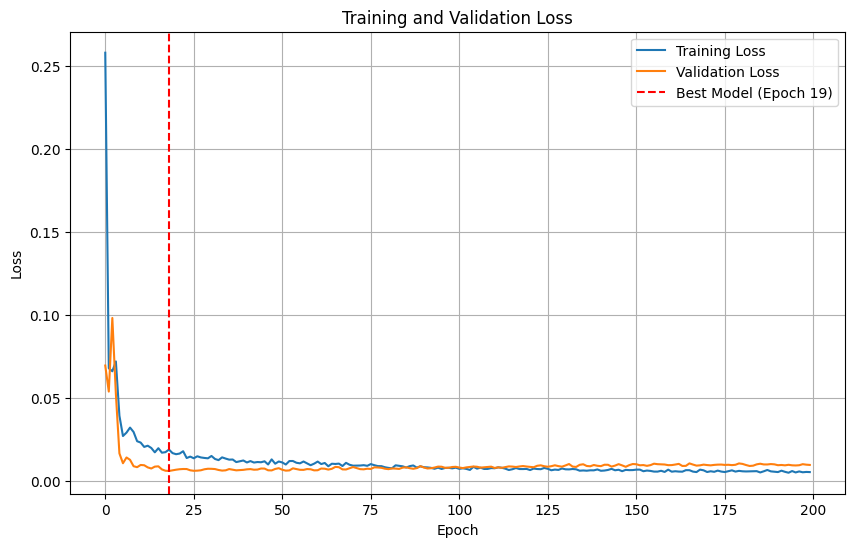

In [10]:
# Graficar las pérdidas
plot_losses(train_losses, val_losses, best_epoch)

In [11]:
# Evaluar en el conjunto de validación
val_loss = evaluate_model(model, val_loader)
print(f"Validation Loss: {val_loss:.4f}")

# Evaluar en el conjunto de prueba
test_loss = evaluate_model(model, test_loader)
print(f"Test Loss: {test_loss:.4f}")

Validation Loss: 0.0098
Test Loss: 0.0050


In [32]:
from utils.metrics import Metric

def filter_invalid_coordinates(predictions_per_user, validation_per_user):
    """
    Filtra las tuplas con coordenadas inválidas (-1, -1) en las trayectorias de validación,
    y sincroniza las predicciones eliminando las mismas posiciones.

    Args:
        predictions_per_user (dict): Diccionario de predicciones por usuario.
        validation_per_user (dict): Diccionario de validaciones por usuario.

    Returns:
        tuple: Diccionarios filtrados de predicciones y validaciones.
    """
    filtered_predictions = {}
    filtered_validation = {}

    for uid, pred_trajs in predictions_per_user.items():
        valid_trajs = validation_per_user[uid]
        filtered_predictions[uid] = []
        filtered_validation[uid] = []

        for pred_traj, valid_traj in zip(pred_trajs, valid_trajs):
            filtered_pred_traj = []
            filtered_valid_traj = []

            for pred_point, valid_point in zip(pred_traj, valid_traj):
                # Validar que las coordenadas del target no sean (-1, -1)
                if valid_point[2] != -1 and valid_point[3] != -1:
                    filtered_pred_traj.append(pred_point)
                    filtered_valid_traj.append(valid_point)

            if filtered_pred_traj and filtered_valid_traj:  # Solo agregar si hay datos válidos
                filtered_predictions[uid].append(filtered_pred_traj)
                filtered_validation[uid].append(filtered_valid_traj)

    return filtered_predictions, filtered_validation






def evaluate_metrics(model, dataloader, metrics: list[Metric], target_days=7):
    """
    Evalúa el modelo usando los datos estructurados en DataLoaders y calcula métricas.

    Args:
        model: Modelo entrenado.
        dataloader (DataLoader): DataLoader con los datos estructurados.
        metrics (list[Metric]): Lista de instancias de métricas.
        target_days (int): Número de días de predicción.

    Returns:
        dict: Diccionario con las métricas calculadas.
    """
    model.eval()  # Configurar el modelo en modo evaluación
    device = next(model.parameters()).device

    predictions_per_user = {}
    validation_per_user = {}

    with torch.no_grad():
        for X, y, _, _ in dataloader:
            # Mover datos al dispositivo
            X, y = X.to(device), y.to(device)

            # Predicciones del modelo
            preds = model(X)

            # Convertir a numpy
            preds = preds.cpu().numpy()
            y = y.cpu().numpy()

            # Extraer la última columna del input para determinar los días
            batch_size, seq_len, _ = X.shape
            last_day_in_input = (
                X[:, -1, 1].cpu().numpy().astype(int)
            )  # Último día en entrada

            # Generar días y timeslots
            timeslots = np.arange(seq_len)  # Secuencia relativa dentro de la ventana
            pred_days = timeslots // 48  # Convertir índice a días
            pred_times = timeslots % 48  # Calcular el timeslot

            for i in range(batch_size):
                uid = int(X[i, 0, 0].cpu().numpy())  # UID del usuario
                start_day = last_day_in_input[i] + 1  # Día inicial de predicción

                # Agregar el offset de días
                absolute_days = pred_days + start_day

                pred_traj = []
                actual_traj = []

                for j in range(seq_len):
                    pred_point = preds[i, j]
                    target_point = y[i, j]

                    pred_traj.append(
                        (
                            int(absolute_days[j]),  # Día absoluto
                            int(pred_times[j]),  # Timeslot
                            float(pred_point[0]),  # Coordenada x
                            float(pred_point[1]),  # Coordenada y
                        )
                    )

                    actual_traj.append(
                        (
                            int(absolute_days[j]),  # Día absoluto
                            int(pred_times[j]),  # Timeslot
                            float(target_point[0]),  # Coordenada x
                            float(target_point[1]),  # Coordenada y
                        )
                    )

                if uid not in predictions_per_user:
                    predictions_per_user[uid] = []
                    validation_per_user[uid] = []

                predictions_per_user[uid].append(pred_traj)
                validation_per_user[uid].append(actual_traj)

    # Uso después de estructurar las trayectorias
    predictions_per_user, validation_per_user = filter_invalid_coordinates(
        predictions_per_user, validation_per_user
    )
        # Calcular métricas
    results = {}
    for metric in metrics:
        print(f"Calculando métrica: {metric.__class__.__name__}")
        score = metric.calculate(
            list(predictions_per_user.values()), list(validation_per_user.values())
        )
        results[metric.__class__.__name__] = score

    return results

In [34]:
from utils.metrics import DTWMetric, GeoBLEUMetric, LPPMetric, MAEMetric

# Instanciar métricas
metrics_instances = [
    LPPMetric(),
    MAEMetric(),
    # GeoBLEUMetric(),
    # DTWMetric(),
]
# Todo Mirar el testloader a ver xq es que hay pocas targets  y verificar sis e estan creando todas las seciencias en el target
# Generar trayectorias estructuradas
trajectories = evaluate_metrics(model, test_loader, metrics_instances)

# Preparar datos para métricas
predictions_per_user = [user_data["predictions"] for user_data in trajectories.values()]
validation_per_user = [user_data["validation"] for user_data in trajectories.values()]


# Evaluar métricas
results = {}
for metric in metrics_instances:
    metric_name = metric.__class__.__name__
    results[metric_name] = metric.calculate(
        predictions_per_user[0], validation_per_user[0]
    )

# Mostrar resultados
print("Resultados de las Métricas:")
for metric_name, score in results.items():
    print(f"{metric_name} score: {score:.4f}")

Calculando métrica: LPPMetric


IndexError: list index out of range

In [13]:
def plot_user_predictions_by_day(
    model, user_id, df, scaler, seq_days=15, timesteps_per_day=48, days_to_plot=None
):
    """
    Genera y grafica las predicciones y valores reales para un usuario específico, organizados en una cuadrícula.
    Cada gráfico representa un día.

    :param model: Modelo entrenado.
    :param user_id: ID del usuario.
    :param df: DataFrame con los datos.
    :param scaler: Scaler usado para normalizar los datos.
    :param seq_days: Número de días en la secuencia.
    :param timesteps_per_day: Número de timesteps por día.
    :param days_to_plot: Lista de días específicos a graficar (opcional).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Filtrar los datos del usuario
    user_data = df[df["uid"] == user_id].copy()

    # Normalizar los datos
    user_data, _ = normalize_data(user_data)

    # Rellenar los días con padding
    user_data = pad_days_with_template_and_padding(
        user_data, timesteps_per_day=timesteps_per_day
    )

    # Crear dataset del usuario
    dataset = SimpleNNDataset(user_data, seq_days=seq_days)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # Generar predicciones
    data_by_day = {}
    with torch.no_grad():
        for X, y, _, target_mask in dataloader:
            X, y, target_mask = (
                X.to(device),
                y.to(device),
                target_mask.to(device),
            )
            preds = model(X)

            # Recortar las predicciones para que coincidan con el target
            seq_len = target_mask.shape[1]
            preds = preds[:, :seq_len, :]  # Recortar a la longitud del target

            # Expandir la máscara y filtrar valores válidos
            mask = target_mask.unsqueeze(-1).expand_as(preds)
            preds = preds[mask].view(-1, preds.size(-1)).cpu().numpy()
            y = y[mask].view(-1, y.size(-1)).cpu().numpy()

            # Desnormalizar
            preds = scaler.inverse_transform(preds)
            y = scaler.inverse_transform(y)

            # Obtener día a partir de t_unified
            days = (y[:, 2] // timesteps_per_day).astype(int)
            for day in np.unique(days):
                day_mask = days == day
                if day not in data_by_day:
                    data_by_day[day] = ([], [])
                data_by_day[day][0].append(y[day_mask, :2])  # x, y reales
                data_by_day[day][1].append(preds[day_mask, :2])  # x, y predichos

    # Consolidar los datos por día
    for day in data_by_day:
        data_by_day[day] = (
            np.vstack(data_by_day[day][0]),
            np.vstack(data_by_day[day][1]),
        )

    # Filtrar días a graficar
    days = sorted(data_by_day.keys())
    if days_to_plot is not None:
        days_probe = [day for day in days if day in days_to_plot]
        if len(days_probe) > 0:
            days = days_probe
        else:
            days = days[:10]

    # Configurar la cuadrícula de gráficos
    cols = 5
    rows = (len(days) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
    axes = axes.flatten()

    # Graficar los datos alineados por día
    for i, day in enumerate(days):
        targets, preds = data_by_day[day]

        # Asegurarse de que hay datos para graficar
        if targets.size == 0 or preds.size == 0:
            continue

        x_targets, y_targets = targets[:, 0], targets[:, 1]
        x_preds, y_preds = preds[:, 0], preds[:, 1]

        ax = axes[i]
        ax.grid(color="gray", linestyle="--", linewidth=0.5)
        ax.plot(
            x_targets, y_targets, label="Real", marker="o", color="blue", markersize=4
        )
        ax.plot(
            x_preds, y_preds, label="Predicho", marker="x", color="orange", markersize=4
        )
        ax.set_title(f"Día {day}")
        ax.set_xlabel("Coordenada X")
        ax.set_ylabel("Coordenada Y")
        ax.legend()

    # Eliminar ejes vacíos si sobran espacios
    for j in range(len(days), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

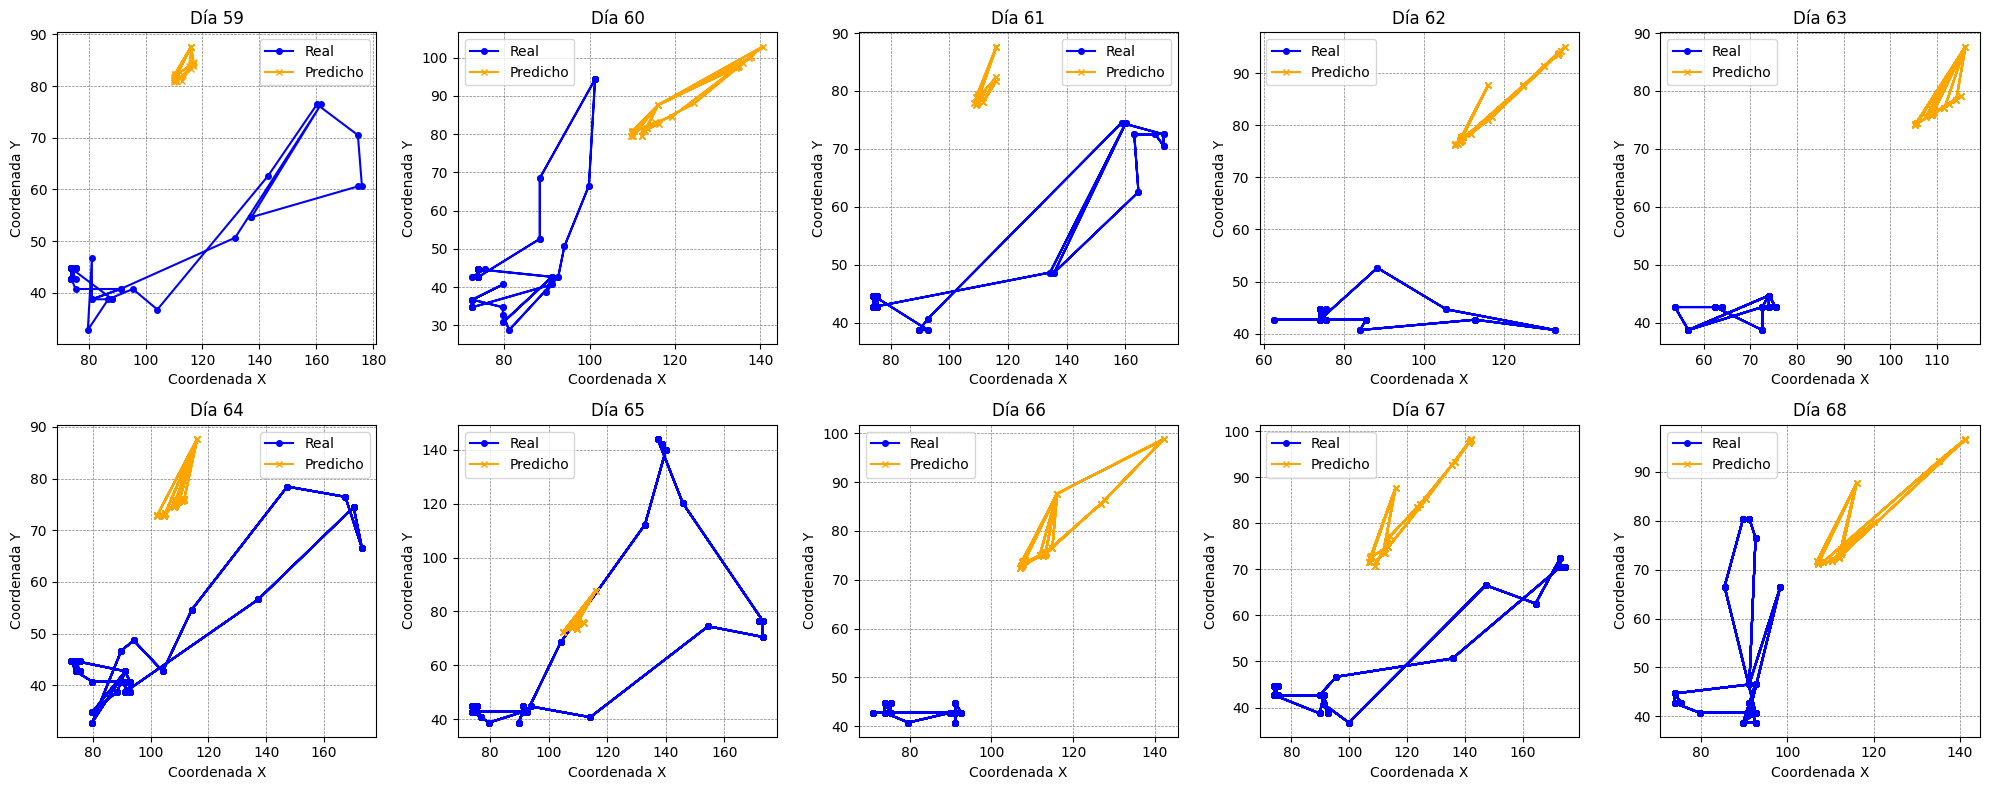

In [15]:
# Graficar las predicciones de un usuario para días específicos
plot_user_predictions_by_day(
    model, user_id=1, df=test_df, scaler=test_scaler, days_to_plot=[44, 45,46]
)

In [16]:
torch.save(model, "../Data/Models/Simple_NN.pth")
print("Modelo completo guardado correctamente en 'simple_nn_complete.pth'.")

Modelo completo guardado correctamente en 'simple_nn_complete.pth'.


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def calculate_metrics(y_true, y_pred):
    """
    Calcula varias métricas de evaluación para predicciones en problemas de regresión.

    :param y_true: Array de valores reales. Shape: (n_samples, n_features)
    :param y_pred: Array de valores predichos. Shape: (n_samples, n_features)
    :return: Diccionario con métricas calculadas.
    """
    # Asegurarse de que las entradas son numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Validar que las formas coincidan
    if y_true.shape != y_pred.shape:
        raise ValueError("Las dimensiones de y_true y y_pred no coinciden.")

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # R² Score
    r2 = r2_score(y_true, y_pred)

    # Distancia Euclidiana Promedio (para coordenadas x, y)
    if y_true.shape[1] >= 2:  # Solo si hay coordenadas en 2D o más
        euclidean_distances = np.sqrt(np.sum((y_true - y_pred) ** 2, axis=1))
        avg_euclidean_distance = np.mean(euclidean_distances)
    else:
        avg_euclidean_distance = None

    # Devuelve las métricas en un diccionario
    metrics = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2,
        "Avg_Euclidean_Distance": avg_euclidean_distance,
    }
    return metrics


In [18]:
def evaluate_and_calculate_metrics(model, data_loader, scaler):
    """
    Evalúa el modelo y calcula métricas de predicción utilizando el conjunto de prueba.

    :param model: Modelo entrenado.
    :param data_loader: DataLoader del conjunto de prueba.
    :param scaler: Scaler usado para desnormalizar los datos.
    :return: Diccionario con métricas calculadas.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X, y, _, target_mask in data_loader:
            X, y, target_mask = (
                X.to(device),
                y.to(device),
                target_mask.to(device),
            )
            preds = model(X)

            # Aplicar máscara para filtrar valores válidos
            mask = target_mask.unsqueeze(-1).expand_as(preds)
            preds = preds[mask].view(-1, preds.size(-1)).cpu().numpy()
            y = y[mask].view(-1, y.size(-1)).cpu().numpy()

            # Desnormalizar
            # preds = scaler.inverse_transform(preds)
            # y = scaler.inverse_transform(y)

            all_preds.append(preds)
            all_targets.append(y)

    # Concatenar todos los datos
    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_targets)

    # Calcular métricas
    metrics = calculate_metrics(y_true, y_pred)
    return metrics


In [19]:
# Evaluar el modelo en el conjunto de prueba y calcular métricas
test_metrics = evaluate_and_calculate_metrics(model, test_loader, test_scaler)

# Mostrar las métricas calculadas
for metric, value in test_metrics.items():
    print(f"{metric}: {value}")


MAE: 0.19997811317443848
MSE: 0.05836644768714905
RMSE: 0.24159148926886695
R²: -0.01412924099713564
Avg_Euclidean_Distance: 0.3952696621417999
